In [1]:
import splines
import torch
import glob
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchsummary import summary
import scipy

In [2]:
back_dict=splines.mat_to_dict()

In [3]:
spline_prims=splines.spline_dict(back_dict)
images=splines.dict_images()

In [4]:
len(spline_prims) # Since languages are 30, should be equal to 30

30

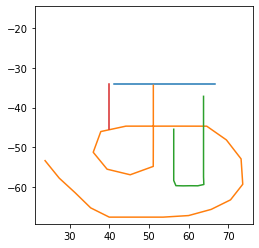

In [5]:
# Let us try to plot a character. Taking an example for a very weird character.
# I found one in the Grantha alphabet. Let us see how its 25-point spline representation looks.

splines.plot_char(spline_prims['Grantha'][1][3][0])
# Note that different colors denote different stokes.

In [6]:
# Our task now remains to train a variational autoencoder on a 2 - unit output for the above.

In [7]:
class encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encode=nn.Sequential(
            nn.Linear(50,25),
            nn.Linear(25,10),
            nn.Linear(10,2)
        )
        
    def forward(self,x):
        return self.encode(x)

In [8]:
class decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decode=nn.Sequential(
            nn.Linear(2,10),
            nn.Linear(10,25),
            nn.Linear(25,50)
        )
        
    def forward(self,x):
        return self.decode(x)

In [9]:
device="cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [10]:
enc=encoder().to(device)
dec=decoder().to(device)

In [11]:
# glob.glob('./**/*.png',recursive=True)
# Will store all filenames of background set images

In [12]:
count=0
for lang in spline_prims :
        # spline_prims[lang][char][inst][0][primitive]
        for i,char in enumerate(spline_prims[lang]) :
            # char = characters of lang
            for j,inst in enumerate(char) :
                # inst = character instance
                for k,primitive in enumerate(inst[0]):
                    count+=1
print('number of total strokes :',count)

number of total strokes : 48762


In [13]:
mat_dict = splines.load_mat("./data_background.mat")

In [14]:
names = [] # Language names
for i in range(len(mat_dict['names'])):
	names.append(str(mat_dict['names'][i].tolist()[0][0]))
print(names)

['Arcadian', 'Armenian', 'Asomtavruli (Georgian)', 'Balinese', 'Bengali', 'Blackfoot (Canadian Aboriginal Syllabics)', 'Braille', 'Cyrillic', 'Early Aramaic', 'Syriac (Estrangelo)', 'Anglo-Saxon Futhorc', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Japanese (hiragana)', 'Inuktitut (Canadian Aboriginal Syllabics)', 'Malay (Jawi - Arabic)', 'Japanese (katakana)', 'Korean', 'Latin', 'Alphabet of the Magi', 'Mkhedruli (Georgian)', 'Burmese (Myanmar)', "N'Ko", 'Ojibwe (Canadian Aboriginal Syllabics)', 'Sanskrit', 'Tagalog', 'Tifinagh']


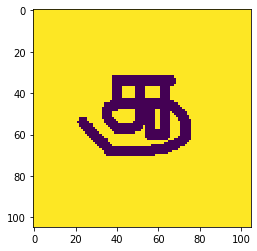

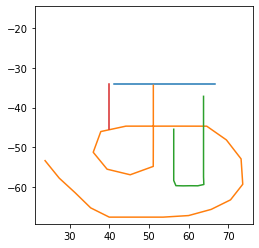

Success !


In [15]:
# images[lang][character][0]['image'][instance][0] -> (105,105) numpy ndarray
# Plotting the same characters, real image vs. the strokes.
img=images['Grantha'][1][0]['image'][3][0]
plt.imshow(img)
plt.show()
splines.plot_char(spline_prims['Grantha'][1][3][0])
print("Success !")

In [16]:
# Now we go on to build the custom dataset class for our data.
# Since our data is not in the form of a direct mapping, what 
# I could have done is that stacked all the data in the form of a matrix. But I will 
# not do that, instead I will use an iterable dataset which is supported by PyTorch dataloader.

In [70]:
from torch.utils.data import IterableDataset, DataLoader
class OmniglotData(IterableDataset):
    """
    Iterable dataset for the 25-spline to 2 vector encoding purpose.
    Expected form to pass data in form of "spline_prims[lang][char][inst][0][primitive]"
    Args:
        data (dict): Data in the same format as used everywhere in our application.
    """
    def __init__(self,data):
        self.data=data
        
    def stream(self):
        # spline_prims[lang][char][inst][0][primitive]
        for lang in self.data:
            for char in self.data[lang]:
                for inst in char:
                    for prim in inst[0]:
                        yield prim.reshape(-1)
    
    def __iter__(self):
        print(count)
        return self.stream()

In [71]:
dataset=OmniglotData(spline_prims)
data_loader=DataLoader(dataset,batch_size=1,shuffle=False)

In [74]:
# # Comment out the .reshape(-1) part in the dataset class to test out this portion.
# # Randomly plotting strokes to see whether they are different.
# samp=[]
# for c,dat in enumerate(data_loader):
#     samp.append(dat)
#     if c>5 :
#         break
# for _,c in enumerate(samp):
# #     print(c.squeeze().detach().cpu().numpy().shape)
#     plt.plot(c.squeeze().detach().cpu().numpy()[:,0],c.squeeze().detach().cpu().numpy()[:,1],'')
# plt.axis('square')
# plt.show()
# # Just to make sure there is no problem with loading spline data

In [73]:
criterion=nn.MSELoss()
optimEnc=optim.Adam(enc.parameters(),lr=1e-4)
optimDec=optim.Adam(dec.parameters(),lr=1e-4)

In [ ]:
# Yaay, everything is working ! Let us train the encoder now !
num_epochs=100
for epoch in range(num_epochs):
    running_loss=.0
    for _,data in data_loader:
        data=data.to(device)
        mid=enc(data)
        out=dec(mid)
        loss=criterion(data,out)
        loss.backward()
        optimEnc.step()
        optimDec.step()
        running_loss+=loss.item()
    print("[%d/%d] Loss : %.4f"%(epoch,num_epochs,running_loss))